## IMPORT LIBRARIES

In [ ]:
!pip install seqeval
import numpy as np
import pandas as pd

from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## LOAD DATASET

In [ ]:
df = pd.read_csv('ner_dataset.csv', encoding="latin1")

In [ ]:
df.head(30)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  47959 non-null    object
 1   Word        1048575 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [ ]:
df.describe()

,Sentence #,Word,POS,Tag
count,47959,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 1,the,NN,O
freq,1,52573,145807,887908


In [ ]:
df['Tag'].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

Unique NER tags are as follows:
* O   : other
* geo : Geographical Entity
* gpe : Geopolitical Entity
* org : Organization
* per : Person
* tim : Time indicator
* art : Artifact
* eve : Event
* nat : Natural Phenomenon

In [ ]:
# Percentage of each class label
df['Tag'].value_counts() / len(df) * 100

O        84.677586
B-geo     3.590015
B-tim     1.939108
B-org     1.920988
I-per     1.645185
B-per     1.620294
I-org     1.600648
B-gpe     1.513483
I-geo     0.707055
I-tim     0.622559
B-art     0.038338
B-eve     0.029373
I-art     0.028324
I-eve     0.024128
B-nat     0.019169
I-gpe     0.018883
I-nat     0.004864
Name: Tag, dtype: float64

**Observation**: Most of the labels are "O" (Other) which means we are dealing with imbalanced dataset.

## HANDLE MISSING VALUES

In [ ]:
df.isnull().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

**Observation**: There are missing values in sentence column, we need to fill each missing value with the nearest-top valid value.

In [ ]:
df['Sentence #'] = df['Sentence #'].fillna(method='ffill')
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [ ]:
# Dropped since we don't need this column
df.drop('POS', axis=1, inplace=True)

In [ ]:
df.isnull().sum()

Sentence #    0
Word          0
Tag           0
dtype: int64

## GENERATE NESTED-SENTENCES LIST

In [ ]:
# Get list of sentences and tags
sentences = df.groupby("Sentence #")["Word"].apply(list).values
tags = df.groupby("Sentence #")["Tag"].apply(list).values

In [ ]:
# Create a pair of (word, tag) inside each sentence
paired_sentences = []
for i in range(len(sentences)):
    sent_pair = list(zip(sentences[i],tags[i]))
    paired_sentences.append(sent_pair)

In [ ]:
# Sample sentence
paired_sentences[18]

[('Doctors', 'O'),
 ('say', 'O'),
 ('they', 'O'),
 ('expect', 'O'),
 ('Mr.', 'B-per'),
 ('Sharon', 'I-per'),
 ('will', 'O'),
 ('make', 'O'),
 ('a', 'O'),
 ('full', 'O'),
 ('recovery', 'O'),
 ('.', 'O')]

## EXTRACT FEATURES (ENCODING)

In [ ]:
#Get vocabulary from unique words and unique tags
unique_words = df["Word"].unique().tolist()
unique_words.append("ENDPAD")
unique_words.append("UNK")
num_words = len(unique_words)

unique_tags = df["Tag"].unique().tolist()
num_tags = len(unique_tags)

In [ ]:
# Create word-to-index and tags-to-index dictionaries
word2index = {w: i for i, w in enumerate(unique_words)}
tag2index = {t: i for i, t in enumerate(unique_tags)}

In [ ]:
# Encode each (word,tag) pair using the above dictionaries
X = [[word2index[w[0]] for w in s] for s in paired_sentences]
y = [[tag2index[w[1]] for w in s] for s in paired_sentences]

In [ ]:
# Choose the max_len as the longest sentence's length
max_len = max([len(s) for s in paired_sentences])

In [ ]:
# Apply padding to each word-vector (to ensure same size for each)
X = pad_sequences(maxlen=max_len, sequences=X, padding="post",value=word2index["ENDPAD"])
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2index["O"])

In [ ]:
# Convert labels to one-hot vector
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## CREATE RNN MODEL

In [ ]:
# RNN Model
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.25))
model.add(TimeDistributed(Dense(num_tags, activation="softmax")))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 104, 104)          3658720   
                                                                 
 dropout_6 (Dropout)         (None, 104, 104)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 104, 128)         86528     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 104, 128)          0         
                                                                 
 time_distributed_3 (TimeDis  (None, 104, 17)          2193      
 tributed)                                                       
                                                                 
Total params: 3,747,441
Trainable params: 3,747,441
No

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
earlyStop = EarlyStopping(monitor='val_loss', patience=2)
checkpointer = ModelCheckpoint(filepath='ner_rnn.h5', save_best_only=True)

In [ ]:
history = model.fit(X_train, np.array(y_train), 
                    batch_size=32, 
                    epochs=10, 
                    validation_split=0.2, 
                    callbacks=[earlyStop, checkpointer])

Epoch 1/10
1080/1080 [==============================] - 239s 221ms/step - loss: 0.1045 - accuracy: 0.9785 - val_loss: 0.0357 - val_accuracy: 0.9902
Epoch 2/10
1080/1080 [==============================] - 238s 220ms/step - loss: 0.0290 - accuracy: 0.9918 - val_loss: 0.0254 - val_accuracy: 0.9925
Epoch 3/10
1080/1080 [==============================] - 239s 221ms/step - loss: 0.0210 - accuracy: 0.9939 - val_loss: 0.0233 - val_accuracy: 0.9931
Epoch 4/10
1080/1080 [==============================] - 240s 222ms/step - loss: 0.0171 - accuracy: 0.9949 - val_loss: 0.0231 - val_accuracy: 0.9932
Epoch 5/10
1080/1080 [==============================] - 245s 227ms/step - loss: 0.0147 - accuracy: 0.9955 - val_loss: 0.0238 - val_accuracy: 0.9932
Epoch 6/10
1080/1080 [==============================] - 238s 220ms/step - loss: 0.0129 - accuracy: 0.9960 - val_loss: 0.0241 - val_accuracy: 0.9931


## EVALUATE PERFORMANCE OF TEST SET

<Axes: >

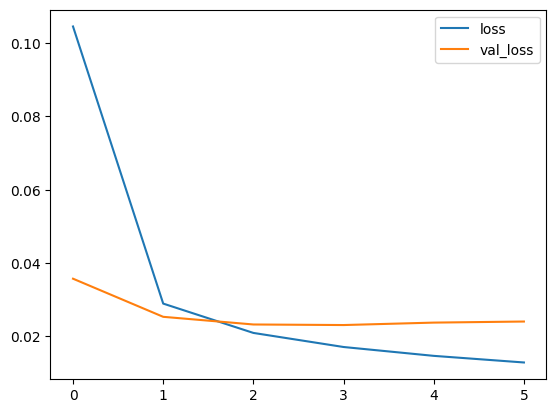

In [ ]:
# Plot the losses
losses = pd.DataFrame(history.history)
losses[['loss','val_loss']].plot()

In [ ]:
# Make predictions
y_pred = model.predict(X_test)
# Choose class with maximum probability
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test, axis=-1)

150/150 [==============================] - 6s 35ms/step


In [ ]:
# Create index-to-tag dictionary
index2tag = {i: t for t, i in tag2index.items()}

In [ ]:
# Convert each indices back to tags
y_pred = [[index2tag[y] for y in y_s] for y_s in y_pred]
y_true = [[index2tag[y] for y in y_s] for y_s in y_true]

In [ ]:
# Print evaluation metrics and classification report
print("Accuracy score : {:.1%}".format(accuracy_score(y_true, y_pred)))
print("Precision score: {:.1%}".format(precision_score(y_true, y_pred)))
print("Recall score   : {:.1%}".format(recall_score(y_true, y_pred)))
print("F1-score       : {:.1%}".format(f1_score(y_true, y_pred)))

Accuracy score : 99.3%
Precision score: 81.1%
Recall score   : 81.0%
F1-score       : 81.0%


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         art       0.22      0.05      0.08        39
         eve       0.44      0.22      0.29        32
         geo       0.85      0.86      0.85      3776
         gpe       0.97      0.93      0.95      1528
         nat       0.38      0.25      0.30        20
         org       0.65      0.69      0.67      1955
         per       0.73      0.72      0.73      1645
         tim       0.86      0.84      0.85      2056

   micro avg       0.81      0.81      0.81     11051
   macro avg       0.64      0.57      0.59     11051
weighted avg       0.81      0.81      0.81     11051

